In [1]:
%env KERAS_BACKEND=tensorflow
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

env: KERAS_BACKEND=tensorflow


In [2]:
from ipywidgets import interact, FloatSlider

In [3]:
#Keras Functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD,Adam
from keras import metrics

#keras datasets
from keras.datasets import mnist

#keras unilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


### Load Mnist Datasets data

In [4]:
(x_train0,y_train0),(x_test0,y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing data with size %d x %d" %x_test0.shape)

11493376/11490434 [==============================] - 2s 0us/step
There are 60000 training data with size 28 x 28
There are 10000 testing data with size 28 x 28


調整資料長相&單位化

In [5]:
x_train = x_train0.reshape(60000,-1)
x_test = x_test0.reshape(10000,-1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## Autoencoder  
學習一個identity fuction (中間經過壓縮再還原的) (as known as 維度變小)     <br />
這個是由兩個函數所組成，encoder (壓縮 ) and decoder (還原的)   <br />
所以必須要有兩個神經網絡   <br />
但我們實際上不會這樣做，一開始會定義一個大網路，然後從中擷取我們需要的小網路去這樣做。  <br />
變數上我們只在意頭、中間相交處跟尾部的部分。


In [6]:
x = Input(shape=(784,))

enc_1 = Dense(100, activation='sigmoid')
enc_2 = Dense(2, activation='sigmoid')

h = enc_2(enc_1(x))

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

x_hat = dec_1(dec_2(h))

In [7]:
autoencoder = Model(x, x_hat)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               79184     
Total params: 158,186
Trainable params: 158,186
Non-trainable params: 0
_________________________________________________________________


In [8]:
autoencoder.compile(loss='mse', optimizer=Adam())

In [9]:
autoencoder.fit(x_train, x_train, batch_size=1024, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 8s 129us/step - loss: 0.1127
Epoch 2/100
60000/60000 [==============================] - 4s 67us/step - loss: 0.0703
Epoch 3/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.0685
Epoch 4/100
60000/60000 [==============================] - 4s 58us/step - loss: 0.0679
Epoch 5/100
60000/60000 [==============================] - 4s 61us/step - loss: 0.0677
Epoch 6/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.0676
Epoch 7/100
60000/60000 [==============================] - 4s 73us/step - loss: 0.0675
Epoch 8/100
60000/60000 [==============================] - 4s 66us/step - loss: 0.0674
Epoch 9/100
60000/60000 [==============================] - 4s 70us/step - loss: 0.0674
Epoch 10/100
60000/60000 [==============================] - 4s 72us/step - loss: 0.0674
Epoch 11/100
60000/60000 [==============================] - 5s 77us/step - loss: 0.0674: 1s
Epoch 12/100
60000/60000 [==========

60000/60000 [==============================] - 4s 60us/step - loss: 0.0542: 1s
Epoch 95/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.0542
Epoch 96/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0542
Epoch 97/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.0542
Epoch 98/100
60000/60000 [==============================] - 4s 71us/step - loss: 0.0541
Epoch 99/100
60000/60000 [==============================] - 4s 68us/step - loss: 0.0541
Epoch 100/100
60000/60000 [==============================] - 5s 89us/step - loss: 0.0541


## 子模型的取出
為了視覺化和其他應用   <br />
在處理decoder的時候，要特別注意h

In [10]:
Encoder = Model(x, h)
Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [35]:
#h的部分，準備一個假的input
h_input = Input(shape=(2,)) #為了視覺化
Decoder = Model(h_input, dec_1(dec_2(h_input)))

Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


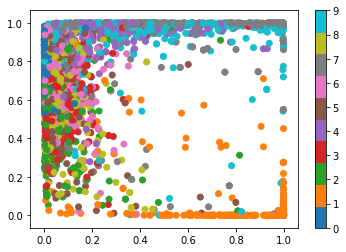

In [51]:
#Encoder 視覺化
indices = np.random.randint(x_test.shape[0], size=3000)
latents = Encoder.predict(x_test[indices])
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap="tab10")
plt.colorbar()
plt.show()

### VAE Model build

In [12]:
enc_1 = Dense(100, activation='sigmoid')
# enc_2 = Dense(2, activation='sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [13]:
x = Input(shape=(784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

### 定義抽樣函數並透過lambda執行

In [14]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [15]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])
dec_x = dec_2(z)
x_hat = dec_1(dec_x)
VAE = Model(x, x_hat)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          78500       input_3[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 2)            202         dense_5[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

### 建立Loss Function (引用助教原先建立的)

In [16]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

###  Compiling and Training Model

In [21]:
VAE.compile(loss=vae_loss, optimizer=Adam())
VAE.fit(x_train, x_train, batch_size=32, epochs=100)

Epoch 1/100
60000/60000 [==============================] - 17s 278us/step - loss: 171.7118
Epoch 2/100
60000/60000 [==============================] - 16s 263us/step - loss: 168.2210
Epoch 3/100
60000/60000 [==============================] - 15s 253us/step - loss: 165.9389
Epoch 4/100
60000/60000 [==============================] - 17s 275us/step - loss: 164.2549
Epoch 5/100
60000/60000 [==============================] - 16s 259us/step - loss: 162.7667
Epoch 6/100
60000/60000 [==============================] - 16s 260us/step - loss: 161.3024
Epoch 7/100
60000/60000 [==============================] - 15s 258us/step - loss: 159.9581
Epoch 8/100
60000/60000 [==============================] - 17s 280us/step - loss: 158.8069
Epoch 9/100
60000/60000 [==============================] - 19s 316us/step - loss: 157.7598
Epoch 10/100
60000/60000 [==============================] - 17s 290us/step - loss: 156.8204
Epoch 11/100
60000/60000 [==============================] - 17s 285us/step - loss: 156.04

60000/60000 [==============================] - 15s 255us/step - loss: 144.0558
Epoch 91/100
60000/60000 [==============================] - 15s 248us/step - loss: 144.0596
Epoch 92/100
60000/60000 [==============================] - 16s 265us/step - loss: 143.9492
Epoch 93/100
60000/60000 [==============================] - 15s 257us/step - loss: 143.9103
Epoch 94/100
60000/60000 [==============================] - 15s 250us/step - loss: 143.7952
Epoch 95/100
60000/60000 [==============================] - 18s 294us/step - loss: 143.8187
Epoch 96/100
60000/60000 [==============================] - 17s 289us/step - loss: 143.7235
Epoch 97/100
60000/60000 [==============================] - 15s 252us/step - loss: 143.7775
Epoch 98/100
60000/60000 [==============================] - 15s 249us/step - loss: 143.7580
Epoch 99/100
60000/60000 [==============================] - 16s 264us/step - loss: 143.6873
Epoch 100/100
60000/60000 [==============================] - 16s 261us/step - loss: 143.6265


# 作業部分_視覺化
### 取出子模型

In [23]:
VAE_Encoder = Model(x, z_mean)

VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 202       
Total params: 78,702
Trainable params: 78,702
Non-trainable params: 0
_________________________________________________________________


In [24]:
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))

VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_9 (Dense)              (None, 784)               79184     
Total params: 79,484
Trainable params: 79,484
Non-trainable params: 0
_________________________________________________________________


## Visualization Encoder

In [40]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, Encoder.predict(x_train[idx: idx+1])))

第 50244 圖的 latent 表示為 [[0.9906934  0.65277326]]


In [52]:
#從 $10000$ 筆測試資料隨機挑選 $3000$ 手寫辨識資料，將其轉換成 latent 表示法，並畫在同一平面上。
#indices = np.random.randint(x_test.shape[0], size=3000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

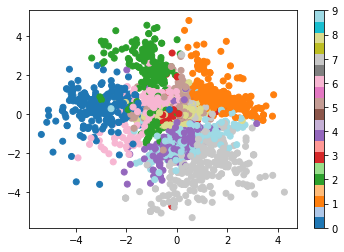

In [53]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## Decoder Visualization

In [28]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [31]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

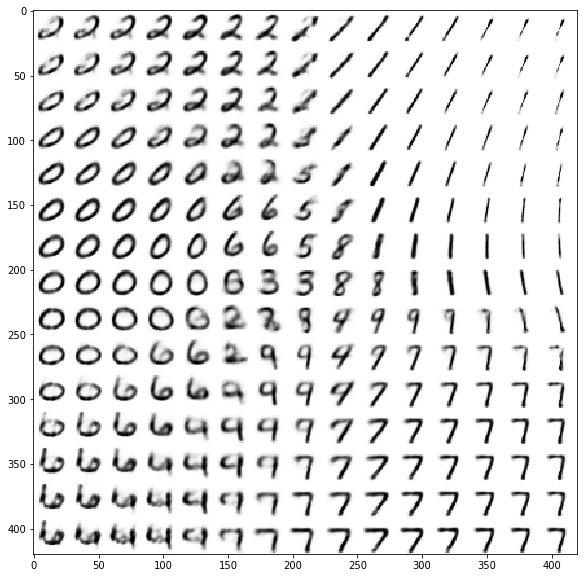

In [32]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
#plt.axis('off')
plt.show()

## 視覺化比較

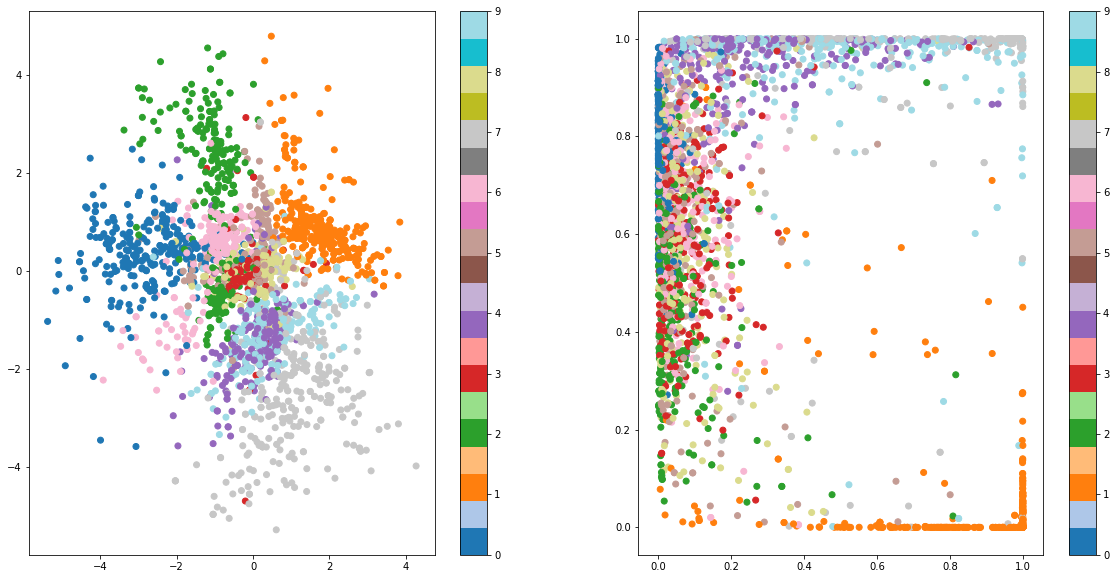

In [54]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(latents[:, 0], latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

## 動態比較

In [59]:
def inBetween(t):
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])

    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0)

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t)

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1)

In [60]:
idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
data_0 = x_train0[idx_1]
data_1 = x_train0[idx_2]

In [61]:
interact(inBetween, t=FloatSlider(value=0.5, 
                                  min=0, 
                                  max=1.0,
                                  step=0.02,))

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.02), Output()), _dom_classes=('w…

<function __main__.inBetween(t)>